# Nguyễn Trung Tuyến - 2151260823

## Mô hình HMM + data cũ

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
import warnings
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler
import plotly as py
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from hmmlearn import hmm
import warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

import matplotlib.font_manager
import matplotlib.pyplot as plt

# Đặt lại kiểu font mặc định
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'DejaVu Sans'})


In [189]:
df = pd.read_csv("./data_thuchanh.csv", encoding="latin-1", sep=';')
df

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.0,1002.0
361,28/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0
362,29/12/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
363,30/12/2021,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,...,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6


In [190]:
feats= ['26']
data_26 = df[feats]
data_26

,26
0,946.1
1,1019.7
2,988.4
3,1010.8
4,1061.5
...,...
360,1002.0
361,1002.0
362,1061.5
363,1022.6


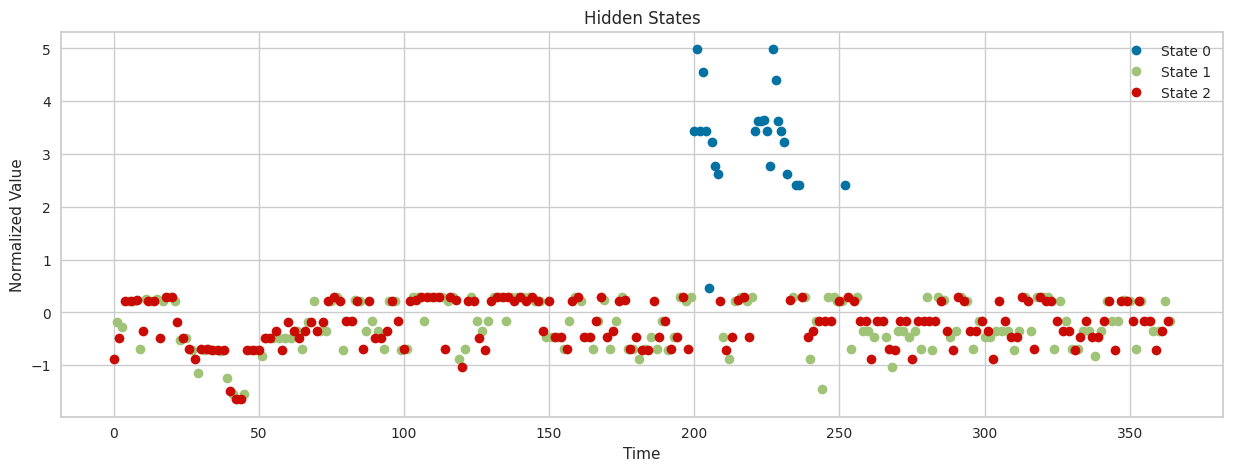

In [191]:
# Chuẩn hóa dữ liệu nếu cần thiết
scaler = StandardScaler()
data_26_scaled = scaler.fit_transform(data_26)

# Định nghĩa số lượng trạng thái ẩn
n_components = 3

# Tạo mô hình HMM
model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100)

# Huấn luyện mô hình HMM
model.fit(data_26_scaled)

# Lấy mẫu từ mô hình - Z là các trạng thái "ẩn"
Z = model.predict(data_26_scaled)

# Vẽ các trạng thái ẩn
def plot_hidden_states(Z, data, n_components):
    plt.figure(figsize=(15, 5))
    for i in range(n_components):
        state = (Z == i)
        plt.plot(np.where(state)[0], data[state], 'o', label=f'State {i}')
    plt.title('Hidden States')
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.show()

plot_hidden_states(Z, data_26_scaled, n_components)

Dự đoán cho 15 ngày tiếp theo (cột 26):
[[1046.75273353]
 [ 955.452588  ]
 [ 976.79704545]
 [1176.75795145]
 [1040.94550921]
 [ 971.33717544]
 [1122.25766864]
 [ 916.32556684]
 [1098.18126084]
 [1091.45913416]
 [1095.76693479]
 [ 957.69862656]
 [1107.69701118]
 [1005.36908773]
 [ 886.82674455]]


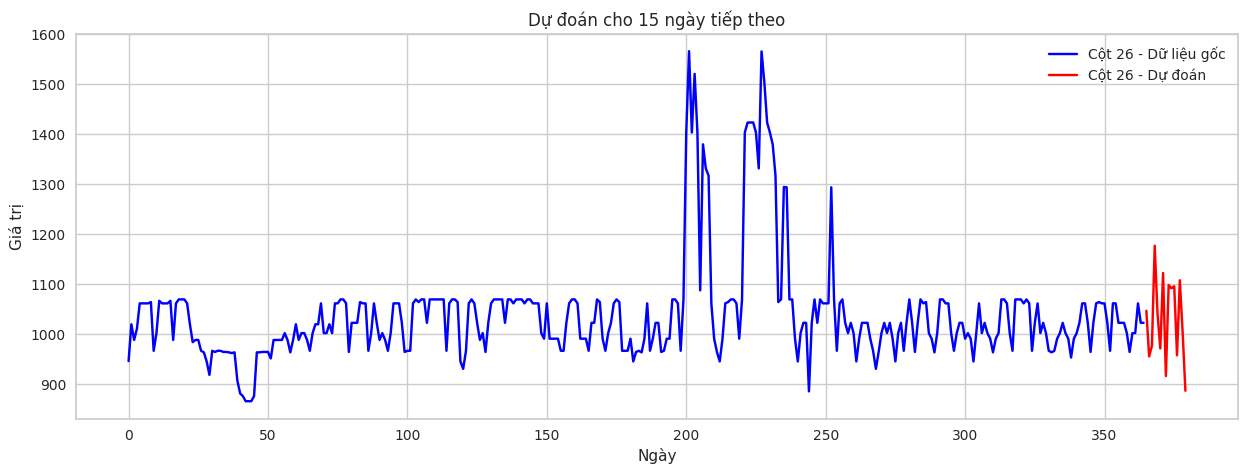

In [203]:
def predict_future(model, num_days, scaler):
    # Lấy trạng thái cuối cùng từ dữ liệu huấn luyện
    last_state = model.predict(data_26_scaled)[-1]
    
    # Dự đoán trạng thái và quan sát trong tương lai
    future_observations, future_states = model.sample(num_days, currstate=last_state)
    
    # Đảo ngược quá trình chuẩn hóa để đưa dữ liệu trở về dạng gốc
    future_observations = scaler.inverse_transform(future_observations)
    
    return future_observations, future_states

# Dự đoán 15 ngày tiếp theo
num_days = 15
future_observations, future_states = predict_future(model, num_days, scaler)

# Hiển thị kết quả dự đoán
print("Dự đoán cho 15 ngày tiếp theo (cột 26):")
print(future_observations)

# Vẽ kết quả dự đoán
def plot_future_predictions(data, future_data, num_days):
    plt.figure(figsize=(15, 5))
    
    # Vẽ dữ liệu gốc
    plt.plot(range(len(data)), data, label='Cột 26 - Dữ liệu gốc', color='blue')
    
    # Vẽ dữ liệu dự đoán
    plt.plot(range(len(data), len(data) + num_days), future_data, '-', label='Cột 26 - Dự đoán', color='red')
    
    plt.title('Dự đoán cho 15 ngày tiếp theo')
    plt.xlabel('Ngày')
    plt.ylabel('Giá trị')
    plt.legend()
    plt.show()

plot_future_predictions(data_26, future_observations, num_days)


## Su dung HMM + Kalman + Data moi

In [193]:
class Random_Variable: 
    def __init__(self, name, values, probability_distribution): 
        self.name = name 
        self.values = values 
        self.probability_distribution = probability_distribution 
        if all(type(item) is np.int64 for item in values): 
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name=name, values=(values, probability_distribution))
        elif all(type(item) is str for item in values): 
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name=name, values=(np.arange(len(values)), probability_distribution))
            self.symbolic_values = values 
        else: 
            self.type = 'undefined'
            
    def sample(self, size): 
        if self.type == 'numeric': 
            return self.rv.rvs(size=size)
        elif self.type == 'symbolic': 
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples 
        
    def probs(self): 
        return self.probability_distribution
    
    def vals(self): 
        print(self.type)
        return self.values 

In [194]:
values = ['S', 'C']
probabilities = [0.5, 0.5]
weather = Random_Variable('weather', values, probabilities)
samples = weather.sample(365)

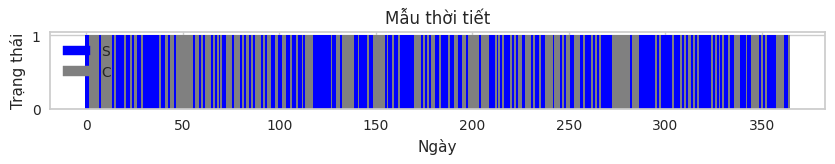

In [195]:
state2color = {} 
state2color['S'] = 'blue'
state2color['C'] = 'grey'

def plot_weather_samples(samples, state2color): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10, 1))
    plt.bar(x, y, color=colors, width=1)
    plt.title('Mẫu thời tiết')
    plt.xlabel('Ngày')
    plt.ylabel('Trạng thái')
    
    # Thêm chú thích
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=color, label=state) for state, color in state2color.items()]
    plt.legend(handles=patches, loc='upper left')
    plt.show()
    
plot_weather_samples(samples, state2color)

In [196]:
def markov_chain(transmat, state, state_names, samples): 
    (rows, cols) = transmat.shape 
    rvs = [] 
    values = list(np.arange(0,rows))
    
    # create random variables for each row of transition matrix 
    for r in range(rows): 
        rv = Random_Variable("row" + str(r), values, transmat[r])
        rvs.append(rv)
    
    states = [] 
    for n in range(samples): 
        state = rvs[state].sample(1)[0]    
        states.append(state_names[state])
    return states


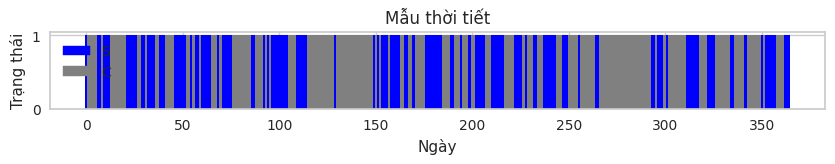

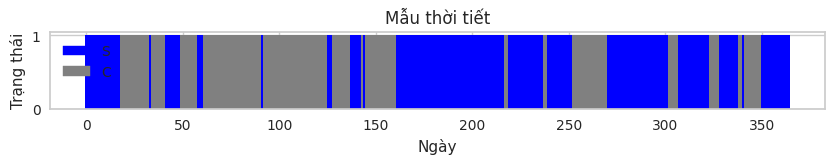

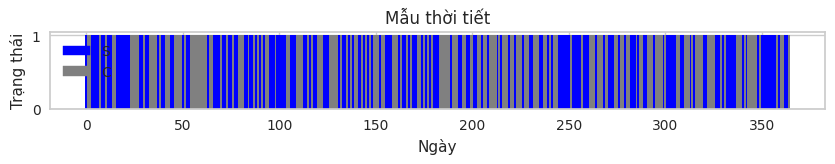

In [197]:
# Ma trận chuyển đổi cho chuỗi Markov
transmat1 = np.array([[0.7, 0.3], 
                      [0.2, 0.8]])

transmat2 = np.array([[0.9, 0.1], 
                      [0.1, 0.9]])

transmat3 = np.array([[0.5, 0.5], 
                      [0.5, 0.5]])

# Đặt tên cho các trạng thái
state_names = ['S', 'C']

# Tạo chuỗi Markov từ ma trận chuyển đổi đầu tiên
samples1 = markov_chain(transmat1, 0, state_names, 365)
plot_weather_samples(samples1, state2color)

# Tạo chuỗi Markov từ ma trận chuyển đổi thứ hai
samples2 = markov_chain(transmat2, 0, state_names, 365)
plot_weather_samples(samples2, state2color)

# Tạo chuỗi Markov từ ma trận chuyển đổi thứ ba
samples3 = markov_chain(transmat3, 0, state_names, 365)
plot_weather_samples(samples3, state2color)


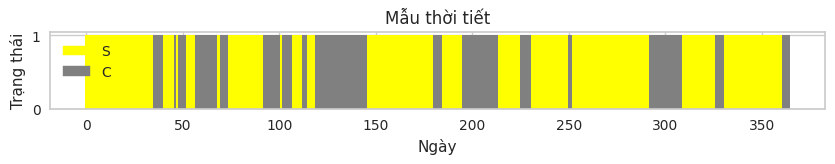

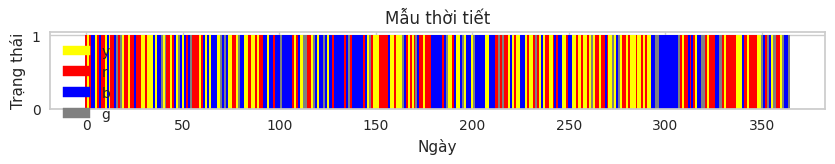

In [198]:
state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'

samples = weather.sample(365)
states = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(states, state2color)

sunny_colors = Random_Variable('sunny_colors', ['y', 'r', 'b', 'g'], 
                              [0.4, 0.4, 0.1, 0.1])
cloudy_colors = Random_Variable('cloudy_colors', ['y', 'r', 'b', 'g'], 
                               [0.1, 0.1, 0.6, 0.2])

def emit_sample(state, sunny_colors, cloudy_colors): 
    if (state == 'S'): 
        sample = sunny_colors.sample(1)[0]
    else: 
        sample = cloudy_colors.sample(1)[0]
    return sample 

samples = [emit_sample(s, sunny_colors, cloudy_colors) for s in states]
state2color = {} 
state2color['y'] = 'yellow'
state2color['r'] = 'red'
state2color['b'] = 'blue'
state2color['g'] = 'grey'
plot_weather_samples(samples, state2color)


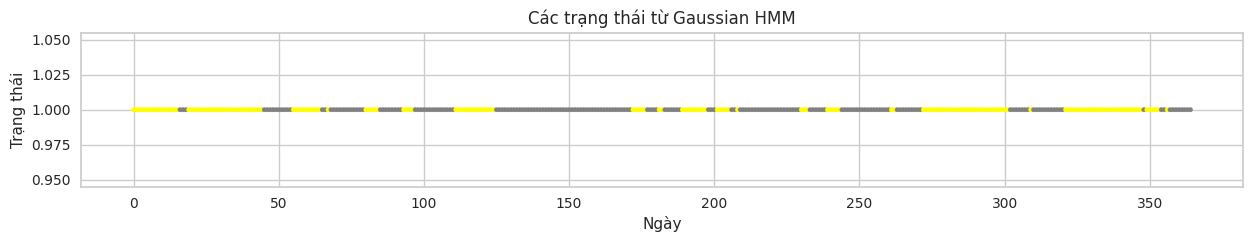

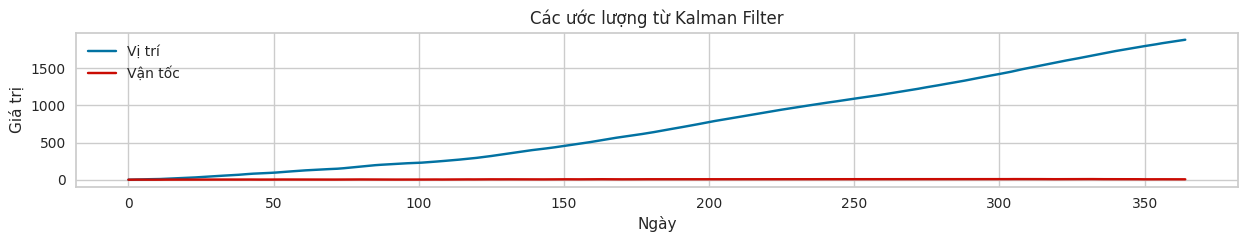

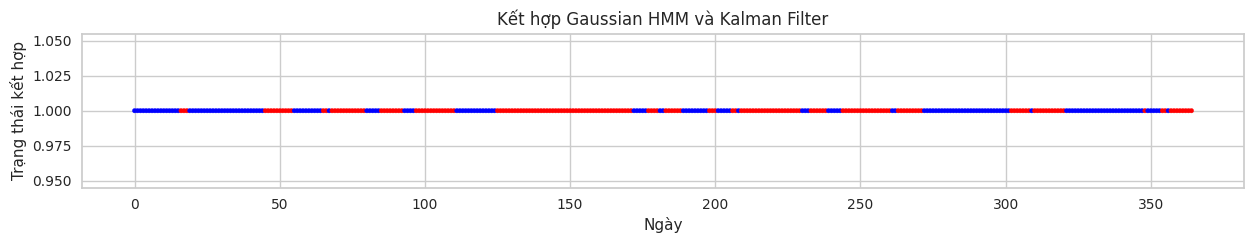

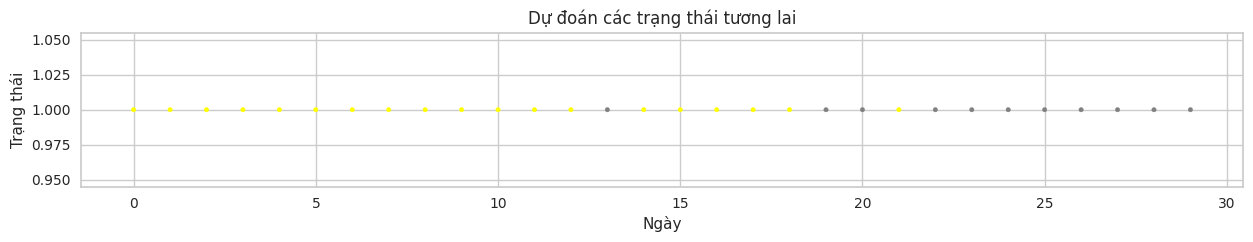

In [199]:

transmat = np.array([[0.9, 0.1], 
                     [0.1, 0.9]])

start_prob = np.array([1.0, 0.0])

means = np.array([[0.0], [3.0]])
covars = np.array([[[1.0]], [[0.5]]])

model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
model.startprob_ = start_prob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

# Tạo dữ liệu
X, Z = model.sample(365)
hmm_states = model.predict(X)

state2color = {0: 'yellow', 1: 'grey'}

# Hàm để vẽ các mẫu thời tiết
def plot_weather_samples(states, state2color, title):
    colors = [state2color[state] for state in states]
    plt.figure(figsize=(15, 2))
    plt.scatter(range(len(states)), [1] * len(states), c=colors, s=10)
    plt.title(title)
    plt.xlabel('Ngày')
    plt.ylabel('Trạng thái')
    plt.show()

# Vẽ các trạng thái từ HMM
plot_weather_samples(hmm_states, state2color, 'Các trạng thái từ Gaussian HMM')

# Thiết lập Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.array([[1, 1], [0, 1]]),
    observation_matrices=np.array([[1, 0]]),
    initial_state_mean=np.array([0, 1]),
    initial_state_covariance=np.array([[1, 0.1], [0.1, 1]]),
    observation_covariance=1,
    transition_covariance=np.array([[0.1, 0], [0, 0.1]])
)

kalman_states, _ = kf.sample(365)

# Vẽ các ước lượng từ Kalman Filter
plt.figure(figsize=(15, 2))
plt.plot(kalman_states[:, 0], 'b-', label='Vị trí')
plt.plot(kalman_states[:, 1], 'r-', label='Vận tốc')
plt.title('Các ước lượng từ Kalman Filter')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.legend()
plt.show()

# Kết hợp các kết quả
combined_states = np.hstack((hmm_states.reshape(-1, 1), kalman_states[:, 0:1]))

# Định nghĩa bản đồ màu mới cho các trạng thái kết hợp
combined_state2color = {(0, 0): 'yellow', (0, 1): 'blue', (1, 0): 'grey', (1, 1): 'red'}
combined_colors = [combined_state2color[(hmm_state, int(kalman_state > 0))] for hmm_state, kalman_state in zip(hmm_states, kalman_states[:, 0])]

# Vẽ kết quả kết hợp
plt.figure(figsize=(15, 2))
plt.scatter(range(len(combined_colors)), [1] * len(combined_colors), c=combined_colors, s=10)
plt.title('Kết hợp Gaussian HMM và Kalman Filter')
plt.xlabel('Ngày')
plt.ylabel('Trạng thái kết hợp')
plt.show()

# Dự đoán các trạng thái tương lai
future_steps = 30
future_states = model.predict(X[-future_steps:])

# Hiển thị các trạng thái tương lai dự đoán
plot_weather_samples(future_states, state2color, 'Dự đoán các trạng thái tương lai')
